In [175]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as plt
import networkx as nx
import ipywidgets as widgets

from IPython.display import display
from IPython.display import clear_output

In [185]:
class Spremnik:
    q = np.array([], dtype=int)
        
    def front(self):
        return self.q[0]
    
    def pop(self):
        val = self.q[0]
        self.q = np.delete(self.q, 0)
        return val
    
    def size(self):
        return self.q.size
    
    def empty(self):
        return self.q.size == 0
    
    # vraca string, treba mi za print(class) poziv
    def __str__(self):
        return np.array2string(self.q, separator=', ')
    
class Queue(Spremnik):
    def push(self, val):
        self.q = np.insert(self.q, len(self.q), val)
        
class Stack(Spremnik):
    def push(self, val):
        self.q = np.insert(self.q, 0, val)

In [177]:
def dohvati_put(roditelj_cvora, pocetni_cvor, ciljni_cvor):
    q = Stack()
    trenutni_cvor = ciljni_cvor
    
    while trenutni_cvor != pocetni_cvor:
        q.push(trenutni_cvor)
        trenutni_cvor = roditelj_cvora[trenutni_cvor]
        
    q.push(trenutni_cvor)
            
    return q

In [178]:
# 1  procedure BFS(G, start_v) is
# 2      let Q be a queue
# 3      label start_v as discovered
# 4      Q.enqueue(start_v)
# 5      while Q is not empty do
# 6          v := Q.dequeue()
# 7          if v is the goal then
# 8              return v
# 9          for all edges from v to w in G.adjacentEdges(v) do
# 10             if w is not labeled as discovered then
# 11                 label w as discovered
# 12                 w.parent := v
# 13                 Q.enqueue(w)


def BFS(G, pocetni_cvor, ciljni_cvor):
    q = Queue()
    q.push(pocetni_cvor)
    
    posjeceni_cvorovi = np.zeros(len(G), dtype=int)
    posjeceni_cvorovi[pocetni_cvor] = True
    
    roditelj_cvora = np.zeros(len(G), dtype=int)
    roditelj_cvora[pocetni_cvor] = pocetni_cvor;

    while q.size():
        trenutni_cvor = q.pop()

        if trenutni_cvor == ciljni_cvor:
            return dohvati_put(roditelj_cvora, pocetni_cvor, ciljni_cvor)
        
        for susjedni_cvor in G[trenutni_cvor]:
            if posjeceni_cvorovi[susjedni_cvor] == False:
                posjeceni_cvorovi[susjedni_cvor] = True
                roditelj_cvora[susjedni_cvor] = trenutni_cvor
                q.push(susjedni_cvor)

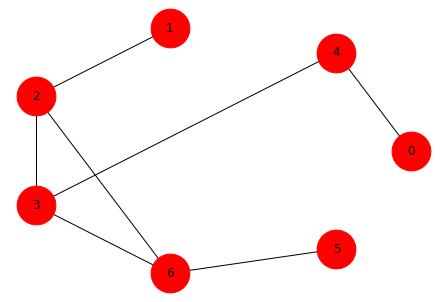

In [179]:
# s ovim generiram random povezan graf
#G = nx.generators.random_graphs.connected_watts_strogatz_graph(7, 3, 0.4, 100)
G = nx.Graph()
G.add_edges_from([(0, 4), (1, 2), (2, 3), (2, 6), (3, 6), (3, 4), (5, 6)], color='red')

pos = nx.circular_layout(G)
nx.draw(G, pos, node_size=1500, with_labels=True, node_color='red')


Output()

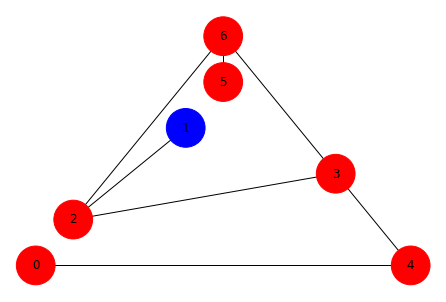

In [189]:
slijedeci = widgets.Button(description=">")
prethodni = widgets.Button(description="<")
output = widgets.Output()

pocetni_cvor = 1
ciljni_cvor = 0

predeni_put = Stack()
put = BFS(G, pocetni_cvor, ciljni_cvor)
color_map = ['red' for i in range(len(G))]
# print(put)

color_map = { i : 'red' for i in range(len(G)) }
node_colors = [color_map[node] for node in G.nodes()]

def ispisi_output():
    clear_output()
    
    node_colors = [color_map[node] for node in G.nodes()]
    
    pos = nx.planar_layout(G)
    nx.draw(G, pos, node_size=1500, with_labels=True, node_color=node_colors)
    
    display(HBox, output)

def slijedeci_clicked(b):
    if put.empty() == False:
        predeni_put.push(put.pop())
        color_map[predeni_put.front()] = 'blue';

    ispisi_output()
    
def prethodni_clicked(b):
    if predeni_put.empty() == False:
        put.push(prederni_put.pop())
        color_map[put.front()] = 'red';
        
    ispisi_output()
    
HBox = widgets.HBox([prethodni, slijedeci])
display(HBox, output)
    
slijedeci.on_click(slijedeci_clicked)
prethodni.on_click(prethodni_clicked)

pos = nx.planar_layout(G)
nx.draw(G, pos, node_size=1500, with_labels=True, node_color=node_colors)